## Sales Forecasting 


Author - Chhavi Arora <br>
Email - chhavigarora@gmail.com 

The purpose of this project is to forecast weekly sales for each department in 45 stores & also to carry out statistical analysis to help improve financial planning of the national retail store. A forecast is based on historical sales data and is done for a particular period of a time in the near future, usually the next calendar year. A sales forecast enables a company to make informed business decisions regarding inventory or cash flow or plan for growth.

Data transformation and machine learning will be used to create a model that will predict weekly_sales when given information on store, department, date & IsHoliday.

The data for this model is relatively simplified as it has very few missing areas. The raw data consists of a training dataset with the features listed above and their corresponding weekly_sales. Twenty percent of this training dataset was split into a test dataset with corresponding weekly_sales so accuracy and error of the model could be determined.

The features in this data set are described as below:

__Store:__ The store number <br>
__Dept:__ The department number <br>
__Date:__ date of sale <br>
__IsHoliday:__ Whether the week is a special holdiay week

In [416]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

## Data Preparation

__Define relevant functions needed in the span of the project__

In [4]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['Weekly_Sales'] )
    plt.ylabel('Weekly_Sales')
    plt.xlabel(col)

#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['Weekly_Sales'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)
    
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['Weekly_Sales'], data = df)
    plt.show()

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

In [3]:
#load data
print("Loading data..")
train_df = load_f('data/data.csv')



#verify data is laoded 
train_df.head()

Loading data..


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


__See lengths and dtypes of the loaded data frames__

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [55]:
train_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


__Check the shape of the dataframes__

In [8]:
#shape of the data
print(train_df.shape)

(421570, 5)


In [237]:
#Number of unique stores in the data set
train_df['Store'].nunique()

45

__Check for missing values -__

In [9]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [15]:
#convert date feature from object to datetime datatype
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")

In [16]:
#verify if the conversion executed successfully
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


## Exploratory Data Analysis

__Descriptive statistics of quantitative data__

In [13]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


__The minimum, maximum and the range of these numbers all seem appropriate for their corresponding columns. The mean and stand ard deviation of do not indicate anything wrong.__

__Are Weekly_Sales normally distributed?__

In [20]:
#compute the kurtosis and skewness of Weekly_Sales
print('Weekly Sales Skewness:', train_df['Weekly_Sales'].skew())
print('Weekly Sales Kurtosis:', train_df['Weekly_Sales'].kurt())
print('\n')
if -0.5 <= train_df['Weekly_Sales'].skew() <= 0.5:
    print('Weekly Sales distribution is approximately symmetric')
elif -0.5 > train_df['Weekly_Sales'].skew() or train_df['Weekly_Sales'].skew() > 0.5:
    print('Weekly_Sales distribution is skewed')

Weekly Sales Skewness: 3.2620081854656657
Weekly Sales Kurtosis: 21.49128990832619


Weekly_Sales distribution is skewed


__Visualize target variable - Weekly_Sales__

In [23]:
#We use IQR to identify potential outliers 
stats = train_df['Weekly_Sales'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds of possible outliers:', lower_bound, upper_bound)

The upper and lower bounds of possible outliers: -25109.653749999998 47395.15625


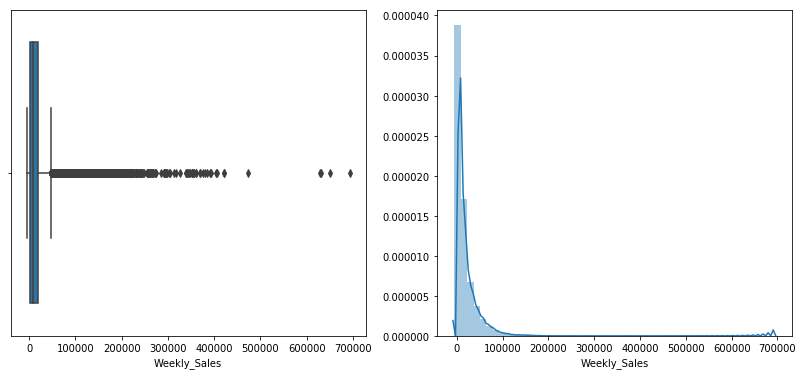

In [24]:
#plot boxplot & distribution plot of the target variable
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(train_df['Weekly_Sales'])
plt.subplot(1,2,2)
sns.distplot(train_df['Weekly_Sales'])

__As seen by the box plot & distribution plot, the distribution of the target variable, weekly_sales is positively skewed with a lot of outliers. Let us deep-dive into the outliers to understand better.__

In [43]:
#examine the outliers below the lower_bound
train_df[train_df['Weekly_Sales'] < lower_bound]

,Store,Dept,Date,Weekly_Sales,IsHoliday


__Looks like we do not have outliers below the lower bound. 
Next, let us examine the outliers above__

In [46]:
#examine the outliers above the upper_bound
train_df[train_df['Weekly_Sales'] > upper_bound]

,Store,Dept,Date,Weekly_Sales,IsHoliday
8,1,1,2010-04-02,57258.43,False
46,1,1,2010-12-24,55931.23,False
63,1,1,2011-04-22,50510.31,False
106,1,1,2012-02-17,54060.10,False
113,1,1,2012-04-06,57592.12,False
143,1,2,2010-02-05,50605.27,False
145,1,2,2010-02-19,47928.89,False
147,1,2,2010-03-05,48397.98,False
151,1,2,2010-04-02,47450.50,False
156,1,2,2010-05-07,47903.01,False


__Looks like there are a lot of outliers.__

### Feature Engineering on Date feature

In [ ]:
#Convert IsHoliday feature into integer values for easier computations
train_df['IsHolidayInt'] = [int(x) for x in list(train_df.IsHoliday)]

In [409]:
from datetime import datetime
strip year from date feature
train_df['year'] = train_df['Date'].dt.year
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,year,month,week_day,IsHolidayInt
0,1,1,24924.50,False,2010,2,4,0
1,1,1,46039.49,True,2010,2,4,1
2,1,1,41595.55,False,2010,2,4,0
3,1,1,19403.54,False,2010,2,4,0
4,1,1,21827.90,False,2010,3,4,0


In [410]:
#strip month from date feature
train_df['month'] = train_df['Date'].dt.month
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,year,month,week_day,IsHolidayInt
0,1,1,24924.50,False,2010,2,4,0
1,1,1,46039.49,True,2010,2,4,1
2,1,1,41595.55,False,2010,2,4,0
3,1,1,19403.54,False,2010,2,4,0
4,1,1,21827.90,False,2010,3,4,0


In [74]:
#strip year from date feature
train_df['week_day'] = train_df['Date'].dt.weekday
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,week_day
0,1,1,2010-02-05,24924.50,False,2010,2,4
1,1,1,2010-02-12,46039.49,True,2010,2,4
2,1,1,2010-02-19,41595.55,False,2010,2,4
3,1,1,2010-02-26,19403.54,False,2010,2,4
4,1,1,2010-03-05,21827.90,False,2010,3,4


In [ ]:
#drop Date column as we already have extracted informations from it - 
train_df = train_df.drop('Date', axis=1)

## Visualize features & trends with Weekly_Sales

__Amount of Departments across all stores__

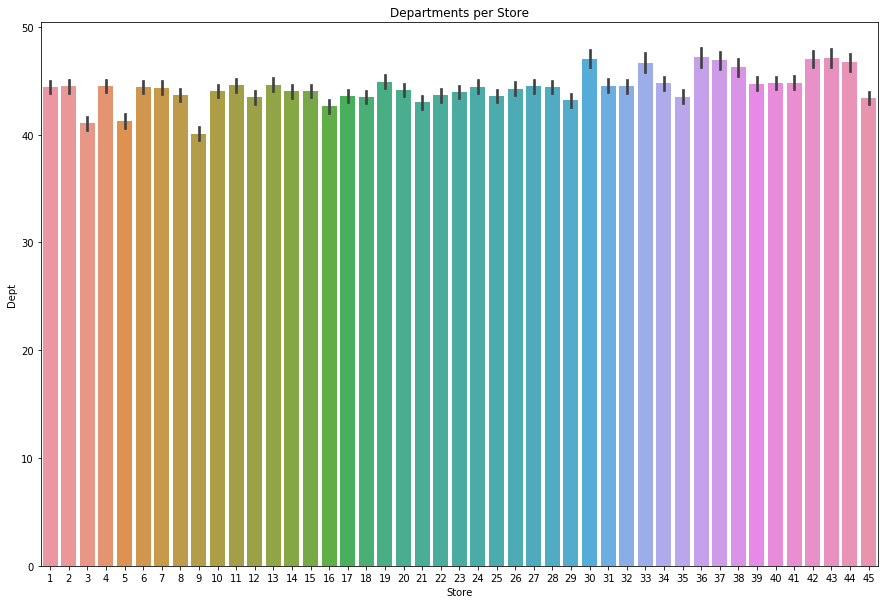

In [394]:
#plot to visualize the variance in departments across all stores
plt.figure(figsize=(15,10))
#ax= sns.barplot(train_df.Store, train_df.Dept, alpha=0.8)
sns.barplot(train_df.Store, train_df.Dept)
plt.title("Departments per Store")
plt.show()

__All the stores seem to have similar amount of departments with slight differences in few. With more information on department types, we could have also visualized the types of departments that are most common across all stores__

__Now let us get a high-level overview of weekly sales performance of all stores.__

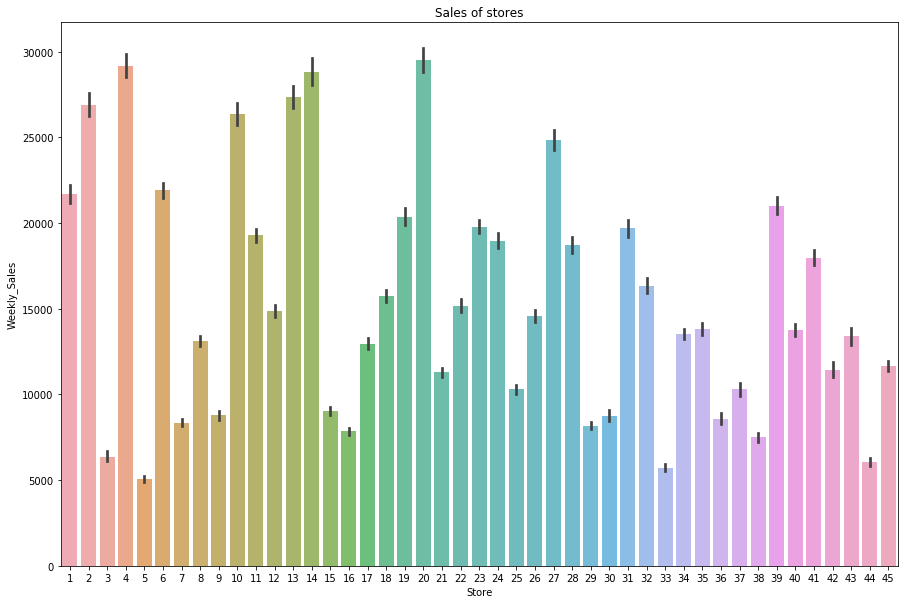

In [396]:
# plot bar chart to see weekly_sales performance of each store
plt.figure(figsize=(15,10))
ax= sns.barplot(train_df.Store, train_df.Weekly_Sales, alpha=0.8)
plt.title("Sales of stores")
plt.show()

__By the above plot, we can see that stores - 4, 14 & 20 are the high performing ones. While, 5th & 44th are amongst the  lowest. There could be a variety of factors effecting these. With more demographical data of these stores, we would be able to visualize better.__

__Now let us zoom in to visualize the monthly trends of sales for each year.__

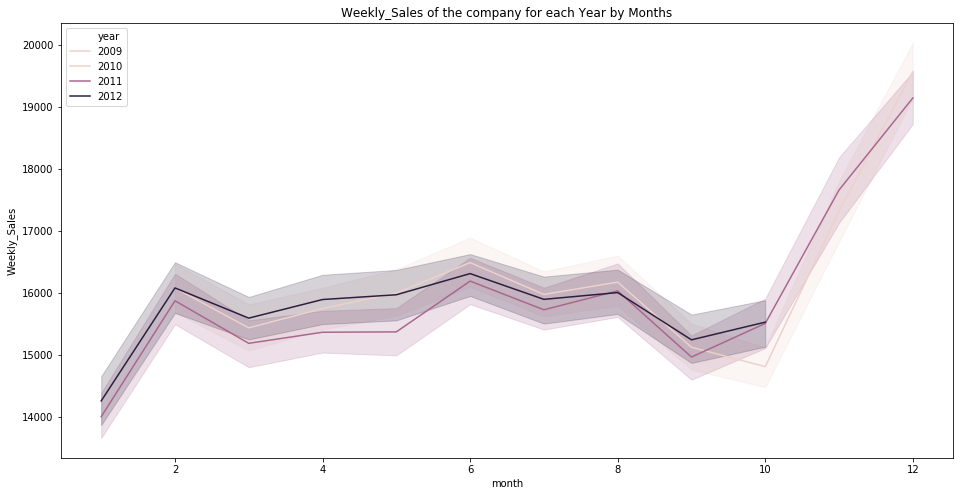

In [347]:
#plot line plot to visualize the trends of sales of the retail company for each year by months
plt.figure(figsize=(16,8))
plt.title('Weekly_Sales of the company for each Year by Months')
plt.xlabel('Month')
plt.ylabel('Sales')
sns.lineplot(train_df.month, train_df.Weekly_Sales, hue = train_df.year)

__There is an obvious seasonality, i.e. peak sales around a time of the year.__

In [307]:
#train_df = ml_train_df.copy()

__Let us picture how the sales vary year-wise during Thanksgiving time.__

Text(0.5, 1.0, 'Weekly Sales of stores')

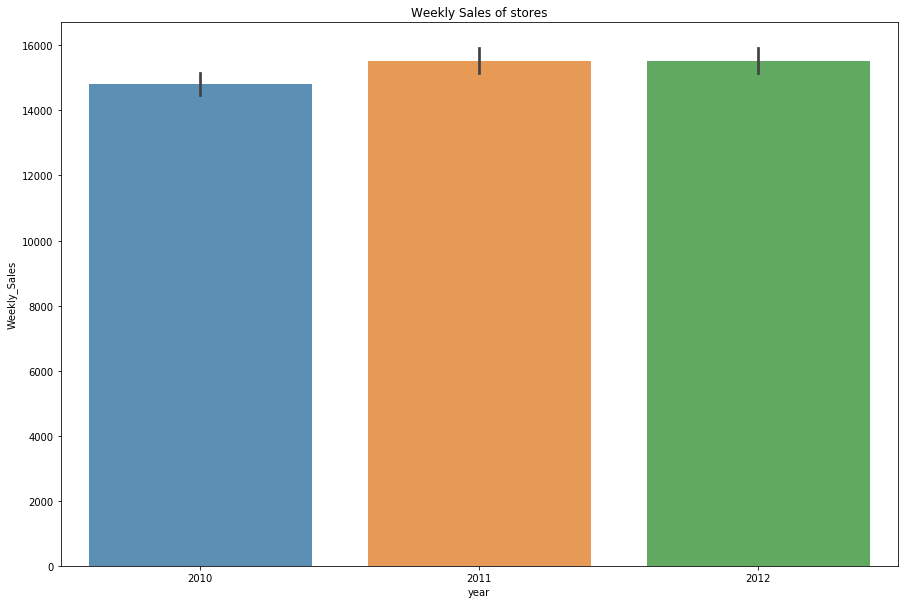

In [401]:
#plot bar chart to visualize sales year-wise for the month of October
october=train_df[train_df['month'] == 10]
plt.figure(figsize=(15,10))
ax= sns.barplot(october.year, october.Weekly_Sales, alpha=0.8)
plt.title("Weekly Sales of stores")

__We can see slight increase in sales with each year during Thanksgiving time.__

__Now let us deep dive into performance of stores for each year during Thanksgiving time.__

In [391]:
#function to plot bar chart of performance of stores for each year during Thanksgiving time-
def thanksgiving_year(year):
    plt.figure(figsize=(15,10))
    plt.title(year)
    mnth = train_df['month'] == 10
    yr = train_df['year'] == year
    october=train_df[mnth & yr]
    ax= sns.barplot(october.Store, october.Weekly_Sales, alpha=0.8)

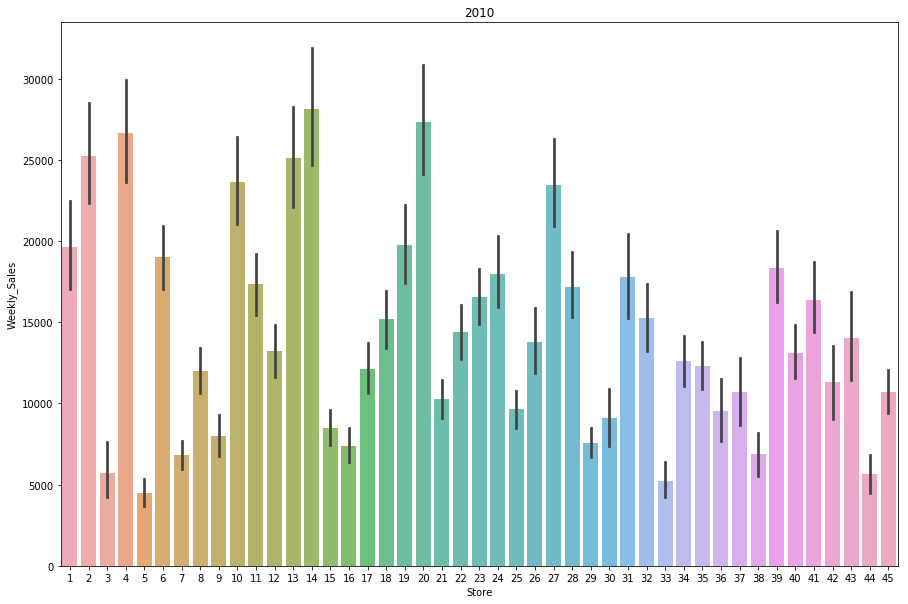

In [362]:
#plot bar chart of performance of stores for 2010 during Thanksgiving time
thanksgiving_year(2010)

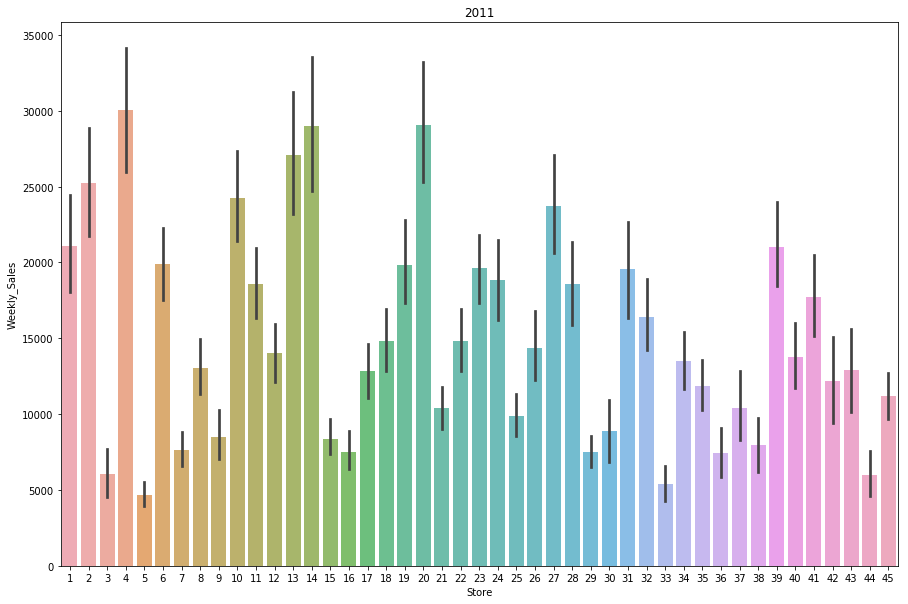

In [363]:
#plot bar chart of performance of stores for 2011 during Thanksgiving time
thanksgiving_year(2011)

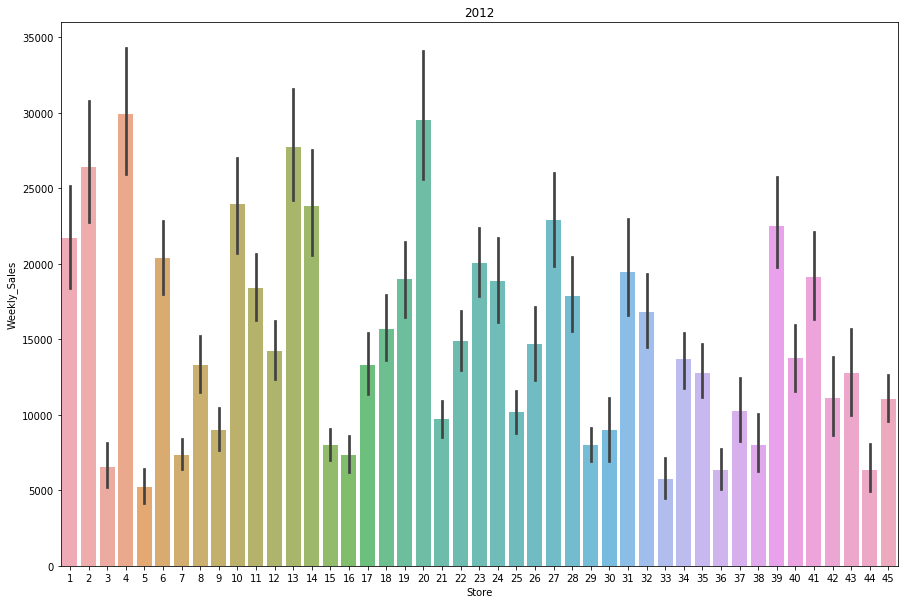

In [364]:
#plot bar chart of performance of stores for 2012 during Thanksgiving time
thanksgiving_year(2012)

__Now let us deep dive into performance of stores for each year during Christmas time.__

In [404]:
#function to plot bar chart of performance of stores for each year during Christmas time-
def christmas_year(year):
    plt.figure(figsize=(15,10))
    plt.title(year)
    mnth = train_df['month'] == 12
    yr = train_df['year'] == year
    october=train_df[mnth & yr]
    ax= sns.barplot(october.Store, october.Weekly_Sales, alpha=0.8)

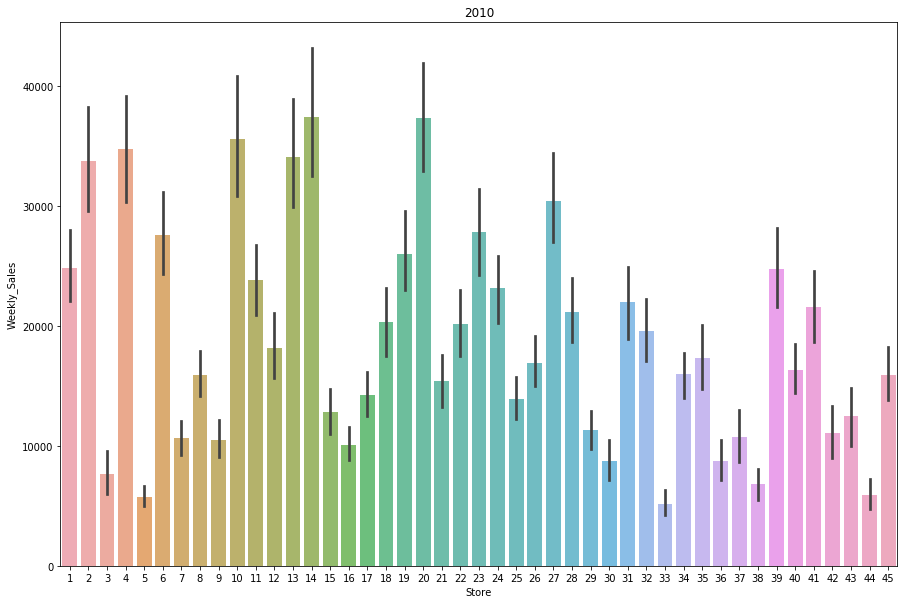

In [366]:
#plot bar chart of performance of stores for 2010 during Christmas time
christmas_year(2010)

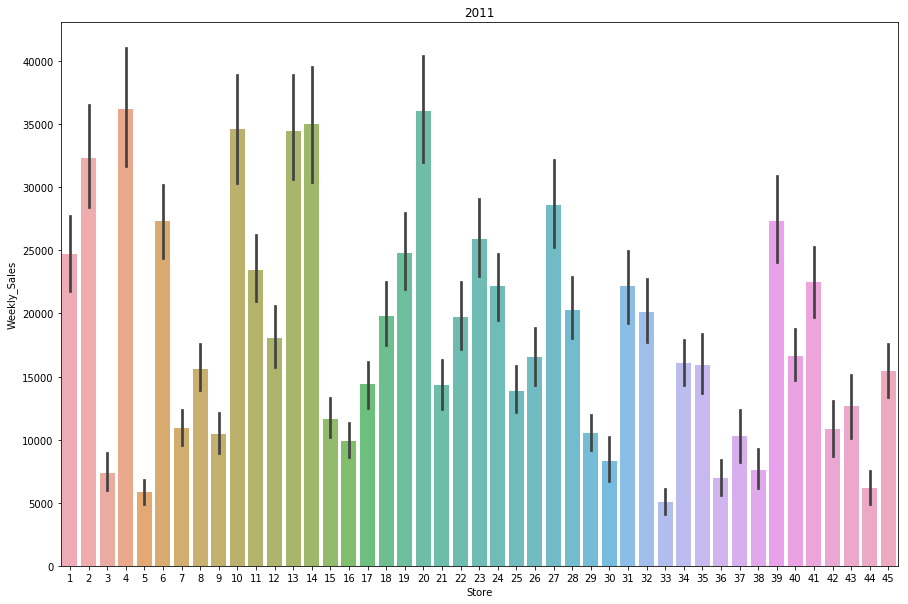

In [368]:
#plot bar chart of performance of stores for 2011 during Christmas time
christmas_year(2011)

__Now let us compare the performance trend of stores for each year during Thanksgiving time to get a better understanding .__

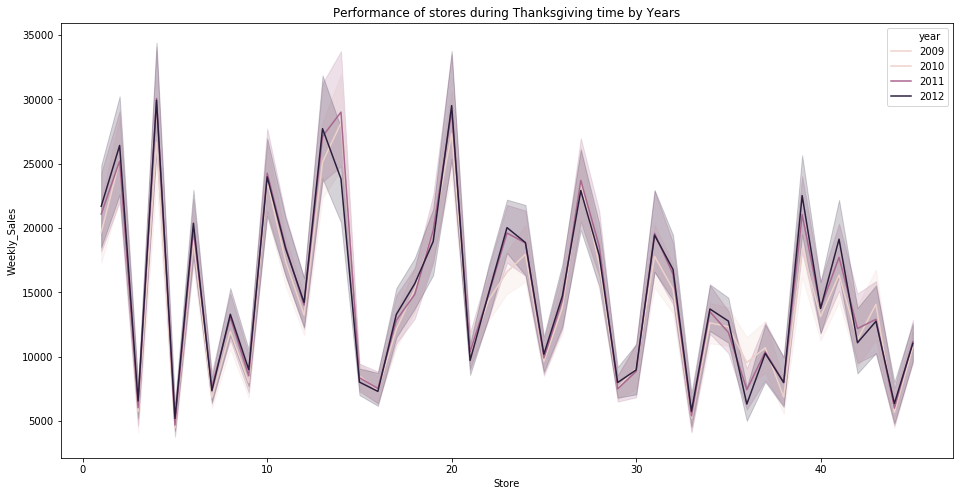

In [385]:
#plot line plot to visualize the trends of store performances for each year during Thanksgiving time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Thanksgiving time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth = train_df['month'] == 10
october=train_df[mnth]
sns.lineplot(october.Store, october.Weekly_Sales, hue = october.year)

__This looks like a seasonal trend of sales store-wide across all years during Thanksgiving time in our data.__

__Now let us compare the performance trend of stores for each year during Christmas time to get a better understanding .__

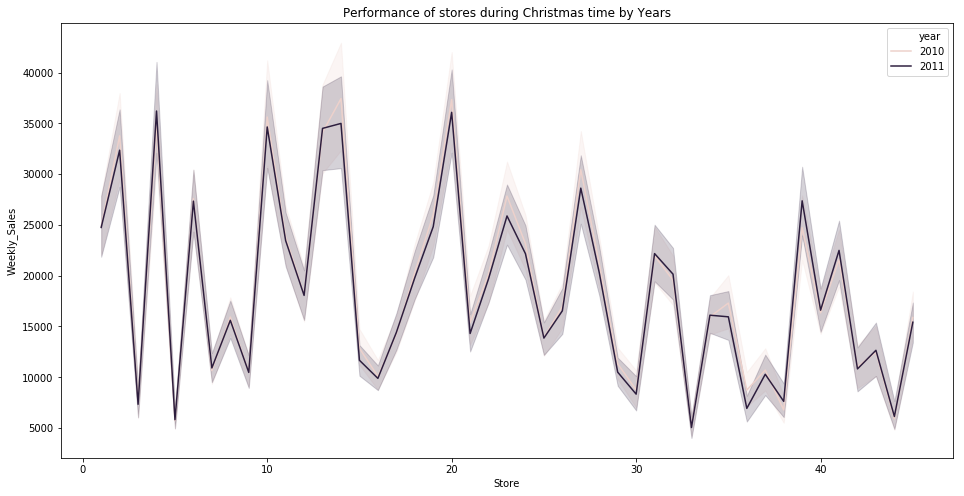

In [388]:
#plot line plot to visualize the trends of store performances for each year during Christmas time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Christmas time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_12 = train_df['month'] == 12
december=train_df[mnth_12]
sns.lineplot(december.Store, december.Weekly_Sales, hue = december.year)

__This looks like a seasonal trend of sales store-wide across all years during Christmas time in our data.__

__Now let us compare the performance trend of stores for each year during Super Bowl time to get a better understanding .__

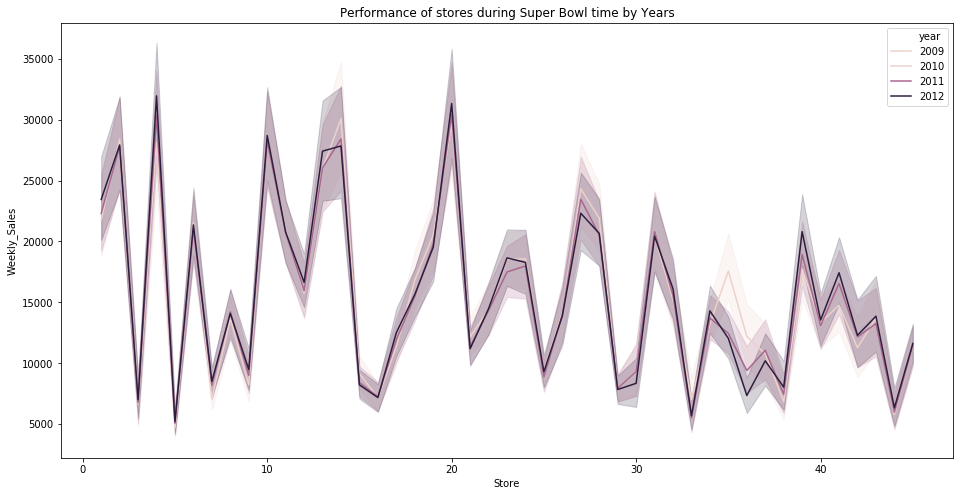

In [389]:
##plot line plot to visualize the trends of store performances for each year during Super Bowl time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Super Bowl time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_02 = train_df['month'] == 2
feb=train_df[mnth_02]
sns.lineplot(feb.Store, feb.Weekly_Sales, hue = feb.year)

__This looks like a seasonal trend of sales store-wide across all years during Super Bowl time in our data.__

__Now let us compare the performance trend of stores for each year during Labor Day time to get a better understanding.__

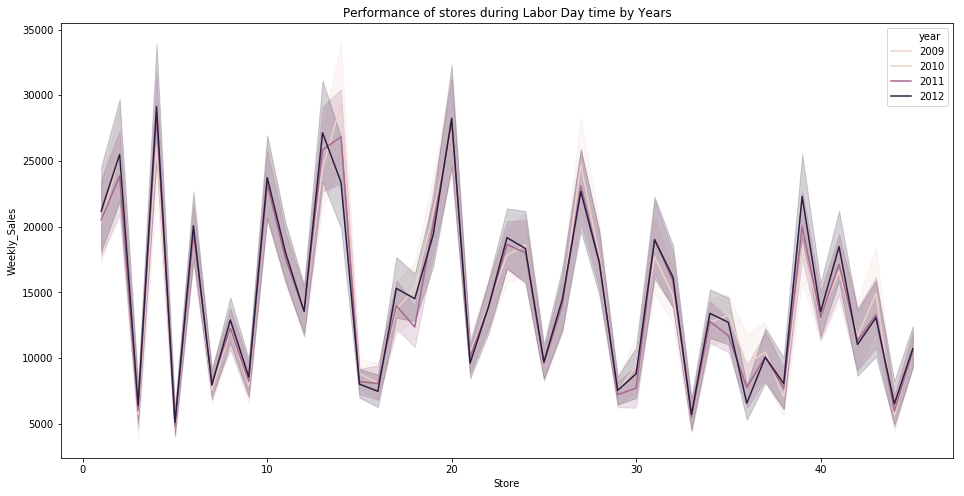

In [390]:
##plot line plot to visualize the trends of store performances for each year during Labor Day time
plt.figure(figsize=(16,8))
plt.title('Performance of stores during Labor Day time by Years')
plt.xlabel('Store')
plt.ylabel('Sales')
mnth_09 = train_df['month'] == 9
sept=train_df[mnth_09]
sns.lineplot(sept.Store, sept.Weekly_Sales, hue = sept.year)

__This looks like a seasonal trend of sales store-wide across all years during Labor Day time in our data.__

__Holiday season, especially Christmas time definitely effect the sales across all stores. However, certain stores have relatively quite low performance. We can possibly understand the reasons for those given more demographical data of all the stores.__

__Now let us visualize the performance of departments with respect to different stores sorted by date.__

(143, 5)


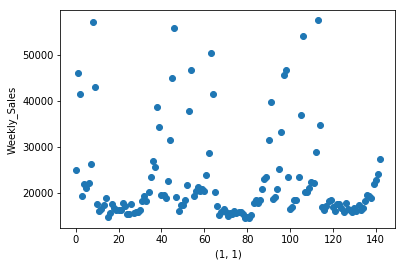

(143, 5)


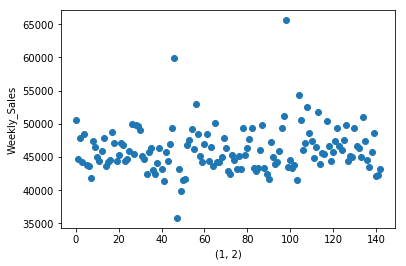

(143, 5)


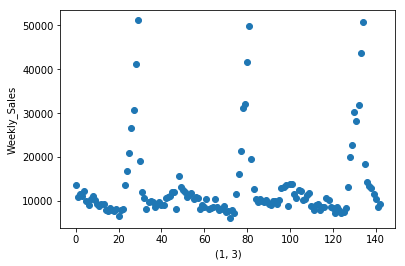

(143, 5)


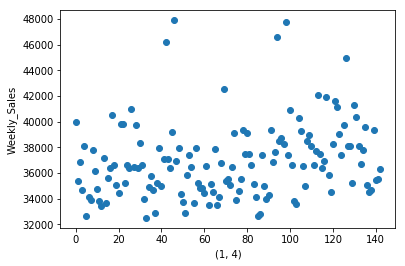

(143, 5)


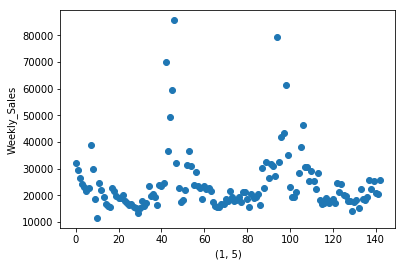

(143, 5)


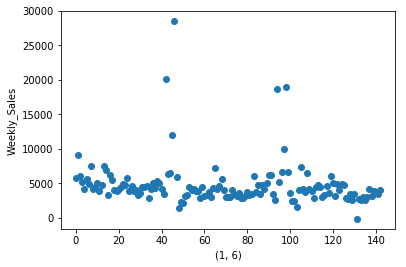

(143, 5)


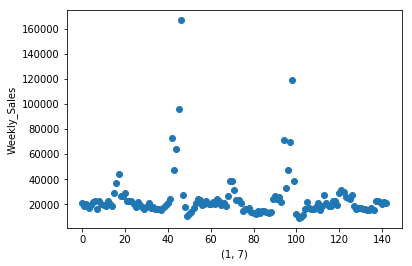

(143, 5)


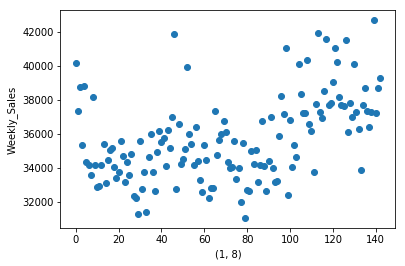

(143, 5)


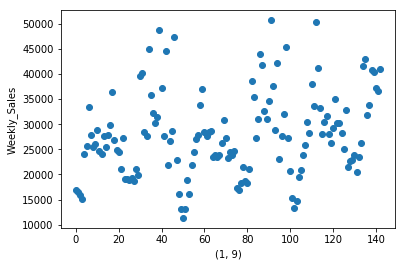

(143, 5)


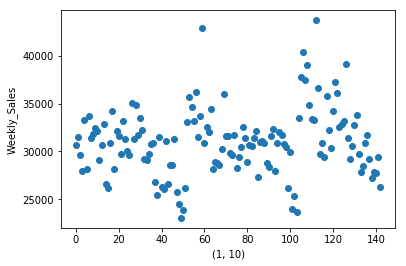

(143, 5)


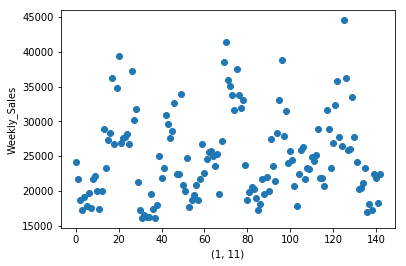

(143, 5)


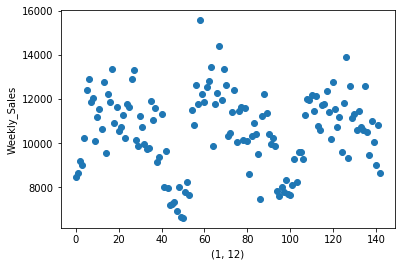

In [57]:
#plot performance of departments for respective stores sorted by date-
count = 0
for store, dept in train_df.groupby(["Store", "Dept"]):
    plt.ylabel('Weekly_Sales')
    plt.xlabel(store)
    print(dept.shape)
    dept = dept.sort_values(by=['Date'])
    plt.scatter(range(len(dept)), dept["Weekly_Sales"])
    plt.show()
    if count > 10:
        break
    count += 1

__Dept-vs-Weekly_Sales plot shows noticable relations, but no obvious linearality has been observed in any plot.__

__In the plots of the weekly sales of each store and department, we see different trends in each plot, indicating that the features may affect the weekly sales of each department in each store differently.__

__Let us visualize the IsHoliday feature.__

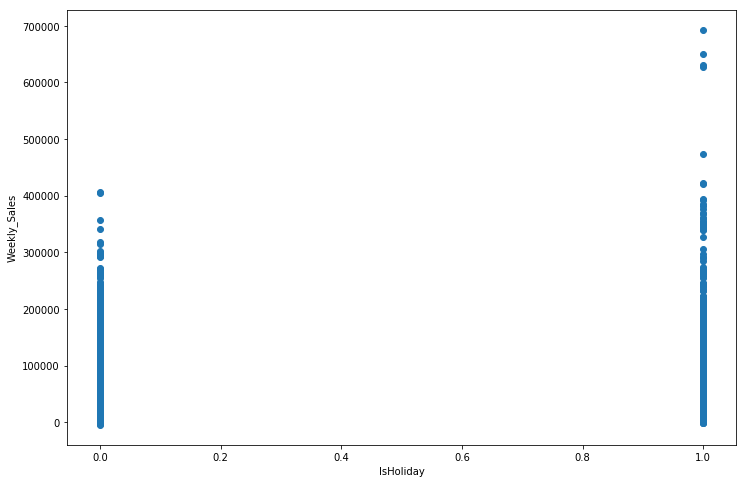

In [406]:
scatter_data(train_df,'IsHoliday')

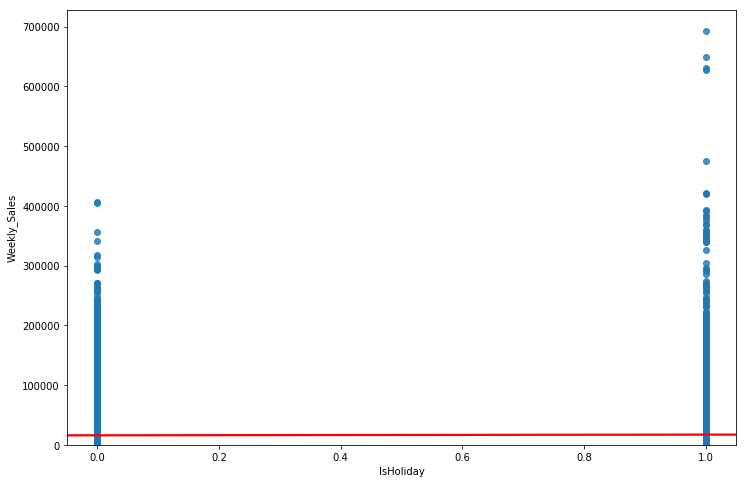

In [407]:
#Fit a regression line to IsHoliday feature to visualize them as a predictor of Weekly_Sales - 
reg_data(train_df,'IsHoliday')

### Correlation between all the features

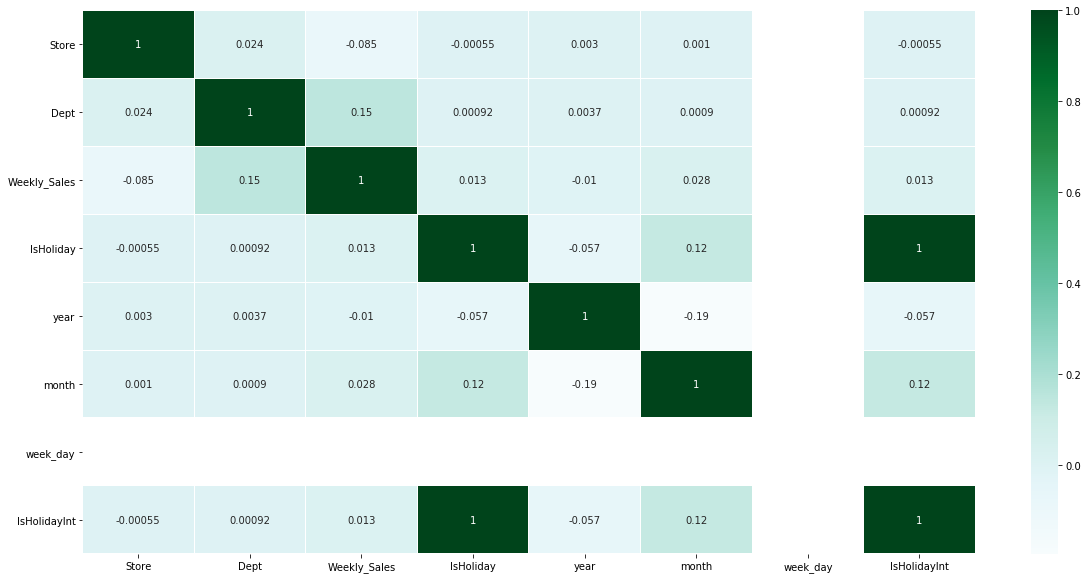

In [102]:
# Plot heatmap of all data with correlation coefficients vis
train_df_corr = train_df.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)

__Pearson correlation coefficient of -1 or +1 also suggest that the relationship between two variables is strong, while two features that are not monotonically related can have a very small correlation coefficient (~0). From the matrix above, we can see that the correlation coefficients between Weekly_Sales and other features are considerbly small, showing that they do not have strong monotonic relations.__

## Modelling & evaluation

__To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the Weekly_Sales are already known.__

In [108]:
#Split the data and assign 'Weekly_Sales' to 'sales_df' and the rest of the features to 'feat_df'. 
feat_df = ml_train_df[ml_train_df.loc[ :, ml_train_df.columns != 'Weekly_Sales'].columns]
sales_df = ml_train_df['Weekly_Sales']
feat_train, feat_test, sales_train, sales_test = train_test_split(feat_df, sales_df, test_size = 0.2, random_state = 1)

In [110]:
#View inputs and outputs of training model
print('Inputs- \n', feat_train.head())
print('Outputs- \n', sales_train.head())

Inputs- 
         Store  Dept  IsHoliday  year  month  week_day  IsHolidayInt
368380     39    72       True  2010     12         4             1
160775     17    25      False  2011      7         4             0
31543       4    16      False  2010      7         4             0
30033       4     4      False  2011      9         4             0
114759     12    60      False  2010      4         4             0
Outputs- 
 368380    55278.88
160775     7229.18
31543     30849.37
30033     53790.29
114759      484.00
Name: Weekly_Sales, dtype: float64


__We will use linear regression here as Weekly_Sales is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, sales_train.__

In [111]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sales_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

__Next, we will view the coefficients of our model -__

In [112]:
#View coeff of Linear Regression object
print(lm.intercept_)
print(lm.coef_)

193986.58939577595
[-157.0096438   111.48853248  336.50064744  -89.87343913  188.93791291
    0.          336.50064744]


__Now that the baseline model is created, it can predict the salaries. The variable yhat is used to store the predictions using the training data.__

In [114]:
#predict Weekly_Sales using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print('First five predictions:' , yhat[0:5])

First five predictions: [18185.03122305 14691.71806166 15819.3200779  14769.46007487
 18901.92461776]


__Mean absolute error (MAE) will be evaluated now along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.__

In [116]:
#print MSE - 
print('Mean Squared Error of our prediction model', mean_squared_error(sales_train, yhat))

Mean Squared Error of our prediction model 499641777.97543436


In [125]:
#print MAE - 

print('Mean Absolute Error of our prediction model', mean_absolute_error(sales_train, yhat))

Mean Absolute Error of our prediction model 15098.562061341856


In [127]:
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, sales_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.030397379822180028 0.0013656748983519626


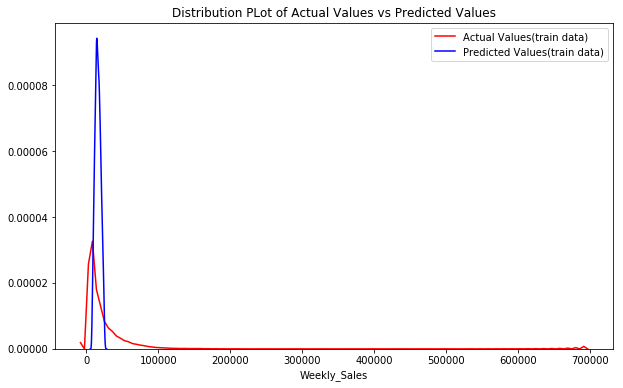

In [128]:
#distribution plot 
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(sales_train, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

__Next, we do the same for the 20% test data to see if the outcome is similar.__

In [130]:
#store test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print('First five predictions(test data)', yhat_test[0:5])

First five predictions(test data) [14938.24256315 17933.44312826 15509.2299234  21305.57741977
 14538.75164399]


In [132]:
#MSE of test data - 
print('Mean Squared Error of test data ', mean_squared_error(sales_test, yhat_test))

Mean Squared Error of test data  501243844.30822295


In [133]:
#MAE of test data - 
print('Mean Absolute Error of test data ', mean_absolute_error(sales_test, yhat_test))

Mean Absolute Error of test data  15139.611781438094


__MAE of test data is slightly more than the MAE of training data__

In [135]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sales_test, cv = 5)
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.03169183550119896 0.0015524984437277017


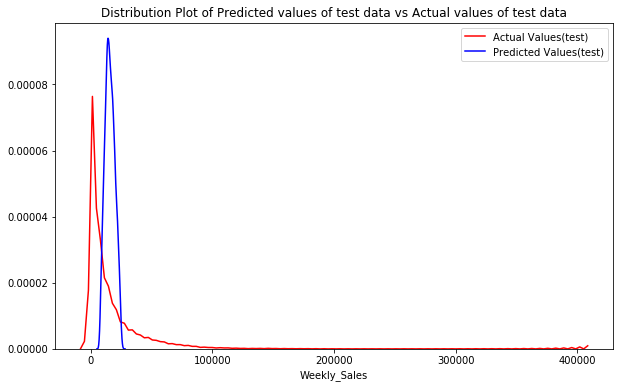

In [136]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sales_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

__Three models that may improve results over the baseline model are -__

1. Apply Polynomial Transformation
2. Use Ridge Regression
3. Use Random Forest

__The shape and features of the training data and testing data will be checked before applying models on them.__

In [138]:
#shape and features -

print('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns) 
print('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print('Number of training weekly_sales-', sales_train.shape)
print('Number of testing weekly_sales-', sales_test.shape)

Number of training samples- (337256, 7) 
 with the features- Index(['Store', 'Dept', 'IsHoliday', 'year', 'month', 'week_day',
       'IsHolidayInt'],
      dtype='object')
Number of testing samples- (84314, 7) 
 with the features- Index(['Store', 'Dept', 'IsHoliday', 'year', 'month', 'week_day',
       'IsHolidayInt'],
      dtype='object')
Number of training weekly_sales- (337256,)
Number of testing weekly_sales- (84314,)


__We will first apply Polynomial Features to already built Linear regression model and see if MAE reduces.__


In [159]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [160]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sales_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [161]:
#make predictions and view first five predictions on train data - 
yhat_pr = poly.predict(feat_train_pr)
print('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [13328.76308239 12136.40785551 17675.1423308  25801.88748807
 11482.86981735]


In [162]:
#Compare first five predicted values vs actual values - 
print('Predicted Values(train)-', yhat_pr[0:5])
print('Actual Values(train)-', sales_train[0:5].values)

Predicted Values(train)- [13328.76308239 12136.40785551 17675.1423308  25801.88748807
 11482.86981735]
Actual Values(train)- [55278.88  7229.18 30849.37 53790.29   484.  ]


In [163]:
#make predictions and view first five predictions on test data - 
yhat_prtest = poly.predict(feat_test_pr)
print('First five predictions(test data)-', yhat_prtest[0:5])

First five predictions(test data)- [ 6047.88563484 14827.79974276  8817.09600595 20797.21017495
  5586.14470702]


In [164]:
#Compare predicted values of test data and actual values of test data - 
print('Predicted values(test)-', yhat_prtest[0:5])
print('Actual values(test)-', sales_test[0:5].values)

Predicted values(test)- [ 6047.88563484 14827.79974276  8817.09600595 20797.21017495
  5586.14470702]
Actual values(test)- [  202.76 16482.   48167.29 21581.64  1315.  ]


In [165]:
#print R-squared values of training and testing data - 
print('R-squared of training data-', poly.score(feat_train_pr, sales_train))
print('R-squared of testing data-', poly.score(feat_test_pr, sales_test))

R-squared of training data- 0.12027250953004454
R-squared of testing data- 0.12365338239472135


In [167]:
#MAE of training and testing data - 
print('MAE of training data-', mean_absolute_error(sales_train, yhat_pr))
print('MAE of testing data-', mean_absolute_error(sales_test, yhat_prtest))

MAE of training data- 13530.50319432289
MAE of testing data- 13549.417060976552


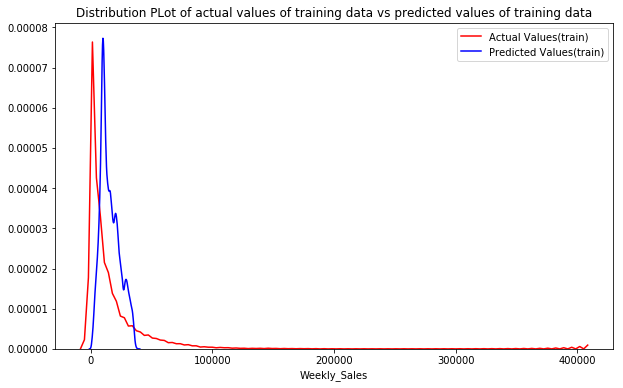

In [168]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sales_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution PLot of actual values of training data vs predicted values of training data')


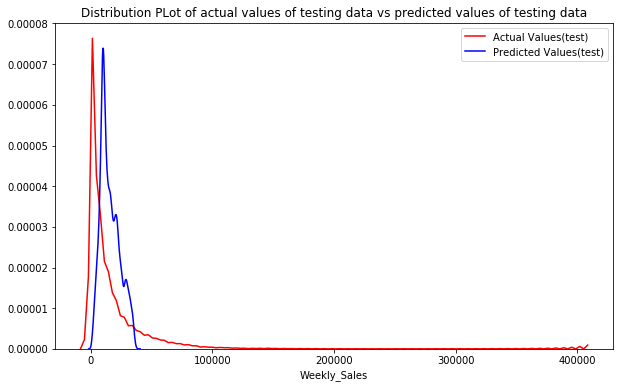

In [169]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')

__Now we will check if applying Ridge regression reduces MAE__

In [171]:
#create a ridge regression object and fit it to training data 
RidgeModel = Ridge(alpha = 1.0)
RidgeModel.fit(feat_train_pr, sales_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [172]:
#predict values of training data and testing data
yhat_Ridge_train = RidgeModel.predict(feat_train_pr)
yhat_Ridge_test = RidgeModel.predict(feat_test_pr)

In [173]:
#compare actual and predicted values of training data 
print('Predicted Values(train)-', yhat_Ridge_train[0:5])
print('Actual Values(train)-', sales_train[0:5].values)

Predicted Values(train)- [13326.98801728 12174.7137631  17656.06680192 25838.2884852
 11464.19914737]
Actual Values(train)- [55278.88  7229.18 30849.37 53790.29   484.  ]


In [175]:
#compare actual and predicted values of testing data 
print('Predicted Values(test)-', yhat_Ridge_test[0:5])
print('Actual Values(test)-', sales_test[0:5].values)

Predicted Values(test)- [ 6032.20613268 14861.7881631   8795.78570824 20828.80592858
  5624.29664544]
Actual Values(test)- [  202.76 16482.   48167.29 21581.64  1315.  ]


In [177]:
#R-squared of training and testing data - 
print('R-squared values(train)-', RidgeModel.score(feat_train_pr, sales_train))
print('R-squared values(test)-', RidgeModel.score(feat_test_pr, sales_test))

R-squared values(train)- 0.12027101809618114
R-squared values(test)- 0.12363283588733753


In [178]:
#MAE of training and testing data - 
print('MAE of training data-', mean_absolute_error(sales_train, yhat_Ridge_train))
print('MAE of testing data-', mean_absolute_error(sales_test, yhat_Ridge_test))

MAE of training data- 13530.550510735924
MAE of testing data- 13549.642208936562


__We see no improvement using alpha = 1.0__

__Let us now use Grid Search to ensure right hyperparameters are used -__

In [179]:
#define the hyperparameter - 
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [180]:
#Create a new Ridge Regression object - 
RM = Ridge()

In [181]:
#create a gridsearch object and pass RM, parameters1 to it. 
Grid = GridSearchCV(RM, parameters1, cv = 5)

In [182]:
#fit the grid search model to the training data - 
Grid.fit(feat_train, sales_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [183]:
#assign best estimator - 
bestRM = Grid.best_estimator_
bestRM

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [185]:
#Test model using test data - 
bestRM.score(feat_test, sales_test)

0.031653496535624326

__We do not see any significant improvement here. Perhaps the performance could improve if we had more data.__

__Next let us try using Random Forest and Fit a Randorm Forest with random_state = 1 for consistency__

In [192]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 7)
RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [193]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sales_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [194]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print('First five predictions-', yhat_RF_test[0:5])

First five predictions- [  296.74619571 12786.8631454  47857.37973881 21036.17930921
  1272.31071429]


In [420]:
#R-squared and MAE of test data - 
print('R-squared of test data-', RF.score(feat_test, sales_test))
print('MAE of test data-', mean_absolute_error(sales_test, yhat_RF_test))

R-squared of test data- 0.957019074710995
MAE of test data- 1783.6031806471572


In [421]:
score = cross_val_score(RF, feat_test, sales_test, cv = 5, scoring = 'r2')
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.9388024333319673 0.009159522727471761


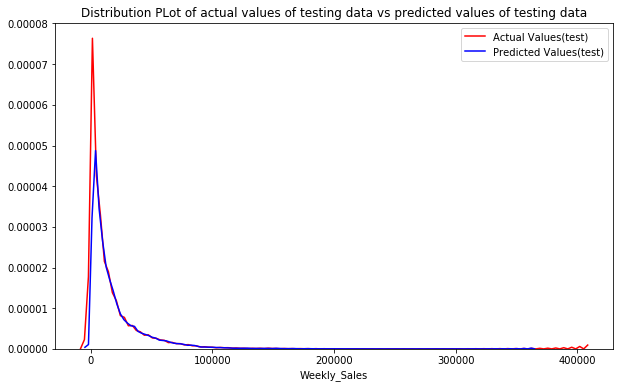

In [197]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_RF_test, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')

__We can see that the Random forest regressor performed best (having the lowest mean absolute error of 1783.60318 and high R-squared of 95%) compared to other models. Therefore, we pick this one to be our base model, and we will fine-tune the model in the next section.__

## Automate and Deploy the model

### Automate pipeline

__To deploy the selected model, a data pipeline will be created to automate the needed transformations once data is given as an input to the model.__

In [212]:
#create pipeline for random forest regression 
input = [('scale', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 7))]
pipe = Pipeline(input)
pipe

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [215]:
#fit the pipeline to the entire training data - 
RFmodel = pipe.fit(feat_df, sales_df)

__The pipeline will Normalize and produce predictions ..__

In [216]:
#make predictions on the test data and print first five - 
ypipe = pipe.predict(feat_df)
ypipe[0:5]

array([29288.30816598, 45406.21163889, 29288.30816598, 29288.30816598,
       22650.61076093])

__Now the model will be saved so it can be used whenever needed.__

In [217]:
filename = 'Sales_forecasting_model.csv'
joblib.dump(RFmodel, filename)

['Sales_forecasting_model.csv']

__We can now load the model to a variable and add new data to it -__

In [218]:
#load model 
loaded_m = joblib.load(filename)

In [219]:
#see results of test data with known Weekly_Sales - 
result = loaded_m.score(feat_test, sales_test)
print(result)

0.978691705605089


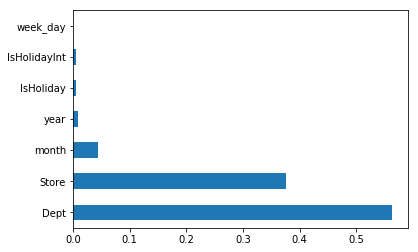

In [228]:
#PLot feature importances -
feat_importances = pd.Series(RF.feature_importances_, index=feat_df.columns)
feat_importances.nlargest(10).plot(kind='barh')

## Summary

__Using a Random Forest Regressor Model gave the most accurate results. The result was a mean absolute error of 1783.6 with the accuracy of 95.7%.__

__This model can be used as a guide when determining Weekly_Sales since it results in a resonable predictions when given information on years of store, department, dates & whether it is a holdiay or not.__